In [287]:
import project_path

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm
from typing import List, Any, Tuple, Dict

from lib.detectors import KS_Detector
from lib.inspector import Inspector
from lib.inspector import OneNightStandInspector
from lib.qmt import execute_programs
from lib.utils import iterate_over
from lib.utils import load_config_and_check
from lib.inspector import retrieve_relevant_file_paths
from lib.inspector import inspec_column_of
from lib.inspector import read_program
from lib.inspector import create_folder_in_interesting_cases
from lib.inspector import copy_bug

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
from copy import deepcopy
from os.path import join
import pathlib
import shutil
import random

In [151]:
import ipywidgets as widgets
from IPython.display import clear_output
from datetime import datetime
def print_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

# Select an Experiment and Clustering

In [153]:
available_experiments = os.listdir("../config/")
available_experiments = [
    filename.replace(".yaml", "") for filename in available_experiments
    if filename.endswith(".yaml")
]
exp_dropdown = widgets.Dropdown(
    options=available_experiments,
    value='qmt_v21',
    description='Experiment to consider:',
    disabled=False,
    style={'description_width': 'max-content'},
    layout={'width': 'max-content'}
)

available_clustering_config_files = os.listdir("../config/clustering/")
available_clustering_config_files = [
    filename.replace(".yaml", "") 
    for filename in available_clustering_config_files
    if filename.endswith(".yaml")
]
cluster_config_dropdown = widgets.Dropdown(
    options=available_clustering_config_files,
    value='cluster_v01',
    description='Clustering file:',
    disabled=False,
    style={'description_width': 'max-content'},
    layout={'width': 'max-content'}
)

display(exp_dropdown)
display(cluster_config_dropdown)

Dropdown(description='Experiment to consider:', index=5, layout=Layout(width='max-content'), options=('qmt_v26…

Dropdown(description='Clustering file:', layout=Layout(width='max-content'), options=('cluster_v01',), style=D…

# Load Data

In [158]:
# FILEPATHS
EXP_FOLDER = exp_dropdown.value
SQL_PATH = os.path.join("..", "data", EXP_FOLDER, "qfl.db")
LOG_PATH = os.path.join("..", "data", EXP_FOLDER, "log_fuzzy.txt")
# READ DATABASE
SQL_CONNECTION = sl.connect(SQL_PATH)
# LOAD DATA
df_data = pd.read_sql("""SELECT * from QFLDATA""", SQL_CONNECTION)
print(f"Total (potentially divergent) comparisons: {len(df_data)}")
try:
    df_crash = pd.read_sql("""SELECT * from CRASHDATA""", SQL_CONNECTION)
    print(f"Total crash in programs: {len(df_crash)}")
    print(f"\tcrashing source: {len(df_crash[~df_crash['exceptions.source'].isna()])}")
    print(f"\tcrashing follow-up: {len(df_crash[~df_crash['exceptions.followup'].isna()])}")
    CRASHED_PROGRAMS = list(df_crash[~df_crash['exceptions.followup'].isna()]["program_id"])
except Exception as e:
    df_crash = pd.DataFrame()
    CRASHED_PROGRAMS = []
    print("No crash data")

Total (potentially divergent) comparisons: 3746
Total crash in programs: 1481
	crashing source: 0
	crashing follow-up: 1481


# Visualize the Clustering

Text(0, 0.5, 'Custer-level Warning Representatives')

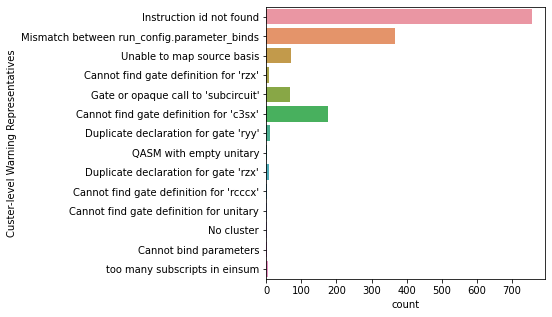

In [398]:
from lib.inspector import cluster_warnings

cluster_config = load_config_and_check(
    f"../config/clustering/{cluster_config_dropdown.value}.yaml")
df_crash_clustered = cluster_warnings(
    df=df_crash,
    warning_col="exceptions.followup",
    cluster_config=cluster_config,  
)
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(
    data=df_crash_clustered,
    y="short_desc",
    ax=ax)
ax.set_ylabel("Custer-level Warning Representatives")

# Sample a Warning (randomly) from a Cluster

In [399]:
cluster_selector = widgets.Dropdown(
    options=df_crash_clustered["short_desc"].unique(),
    value='No cluster',
    description='Cluster to sample:',
    disabled=False,
    style={'description_width': 'max-content'},
    layout={'width': 'max-content'}
)
k_selector = widgets.IntSlider(
    value=10,
    min=3,
    max=100,
    step=1,
    description='To inspect:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
show_top_k_btn = widgets.Button(
    description='Show warnings',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to print the top warnings ',
    icon='fa-eye' # (FontAwesome names without the `fa-` prefix)
)
from IPython.display import clear_output

CURRENT_CLUSTER_WARNINGS = []

def show_top_k_warnings(widget):
    global CURRENT_CLUSTER_WARNINGS
    print(f"TOP {k_selector.value} (raw) warnings by occurence in the given cluster")
    df_single_cluster = df_crash_clustered[
        df_crash_clustered["short_desc"] == cluster_selector.value]
    CURRENT_CLUSTER_WARNINGS = sorted(df_single_cluster["exceptions.followup"].unique())
    df_grouped = df_single_cluster.groupby(
        by=["exceptions.followup"])["index"].count().sort_values(
        ascending=False)
    clear_output()
    display(cluster_selector)
    display(k_selector)
    display(show_top_k_btn)
    display(df_grouped.head(k_selector.value))

show_top_k_btn.on_click(show_top_k_warnings)

display(cluster_selector)
display(k_selector)
display(show_top_k_btn)



Dropdown(description='Cluster to sample:', index=11, layout=Layout(width='max-content'), options=('Instruction…

IntSlider(value=10, continuous_update=False, description='To inspect:', min=3)

Button(description='Show warnings', icon='eye', style=ButtonStyle(), tooltip='Click to print the top warnings …

exceptions.followup
"Gate or opaque call to 'unitary139904679315728' uses 2 qubits but is declared for 1 qubits line 20 file "    1
ParameterExpression with unbound parameters ({Parameter(p_3b4e0b)}) cannot be cast to a float.                1
Name: index, dtype: int64

# Pick Specific Example

In [339]:
warning_selector = widgets.Dropdown(
    options=CURRENT_CLUSTER_WARNINGS,
    description='Specific warning:',
    disabled=False,
    style={'description_width': 'max-content'},
    layout={'width': 'max-content'}
)
check_specific_warning = widgets.Checkbox(
    value=False,
    description='Cluster-Level',
    disabled=False,
    indent=False
)

sample_example_btn = widgets.Button(
    description='Sample',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Sample one example',
    icon='fa-eye' # (FontAwesome names without the `fa-` prefix)
)

def show_program_id(widget):
    global PROGRAM_ID_UNDER_ANALYSIS
    if not check_specific_warning.value:
        df_selection = df_crash_clustered[
            df_crash_clustered["exceptions.followup"] == \
                warning_selector.value]
        print(f"From: {warning_selector.value}")
    elif check_specific_warning.value:
        df_selection = df_crash_clustered[
            df_crash_clustered["short_desc"] == \
                cluster_selector.value]
        print(f"From: {cluster_selector.value}")
    PROGRAM_ID_UNDER_ANALYSIS = random.choice(
        list(df_selection["program_id"]))   
    print_time()
    print(f"PROGRAM_ID_UNDER_ANALYSIS: {PROGRAM_ID_UNDER_ANALYSIS}")

sample_example_btn.on_click(show_program_id)

display(warning_selector)
display(check_specific_warning)
display(sample_example_btn)

Dropdown(description='Specific warning:', layout=Layout(width='max-content'), options=('"Argument \'p_0309ac\'…

Checkbox(value=False, description='Cluster-Level', indent=False)

Button(description='Sample', icon='eye', style=ButtonStyle(), tooltip='Sample one example')

From: ParameterExpression with unbound parameters ({Parameter(p_3b4e0b)}) cannot be cast to a float.
Current Time = 00:01:53
PROGRAM_ID_UNDER_ANALYSIS: d07a2fcab4984eac9da8bf157167cfe3
From: "Argument 'p_8af6c7' in expression cannot be found, line 14 file "
Current Time = 00:05:06
PROGRAM_ID_UNDER_ANALYSIS: 36b61a9fee1442f2a978e71b471282aa


# Visualize the Diff: Source vs FollowUp
Start the timer (aka create a file with the current timestamp and the program id).

In [351]:
BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID_UNDER_ANALYSIS
)
for k, v in BUG_PATHS.items():
    print(f"{k}: {v}")
# inspect relevant properties
inspec_column_of(
    df=df_crash,  # TROUBLESHOOTING change with df_data if the program is from a divergence
    program_id=PROGRAM_ID_UNDER_ANALYSIS, 
    target_col="followup.metamorphic_transformations"
)
print('# SOURCE ---------------')
source_file = read_program(path=BUG_PATHS['source'], color='red')
print("#" + "-" * 80)
print('# FOLLOWUP -------------')
follow_file = read_program(path=BUG_PATHS['followup'], color='blue')
print('# Difference -----------')


from difflib import Differ
  
differ = Differ()

for line in differ.compare(source_file.splitlines(), follow_file.splitlines()):
    print(line)


source: ../data/qmt_v26/programs/source/36b61a9fee1442f2a978e71b471282aa.py
followup: ../data/qmt_v26/programs/followup/36b61a9fee1442f2a978e71b471282aa.py
metadata: ../data/qmt_v26/programs/metadata/36b61a9fee1442f2a978e71b471282aa.json
metadata_exec: ../data/qmt_v26/programs/metadata_exec/36b61a9fee1442f2a978e71b471282aa.json
n hits: 1
['InjectParameters', 'InjectNullEffect', 'ChangeCouplingMap', 'ToQasmAndBack']
# SOURCE ---------------

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(DCXGate(), qargs=[qr[1], qr[0]], cargs=[])
qc.append(CUGate(4.090252435847421,1.7790385712994252,2.7044749753087713,4.578935400765705), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RYYGate(3.960408938945379),

# Copy FollowUp to a New Cell
Change the followup until it stops crashing

In [166]:
get_ipython().set_next_input(follow_file)

# Interactive Delta-Debugging

In [352]:
get_ipython().set_next_input(follow_file)

In [355]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS

p_815e3a = Parameter('p_815e3a')
p_d98ed5 = Parameter('p_d98ed5')
p_e28120 = Parameter('p_e28120')
p_66550b = Parameter('p_66550b')
p_7be84e = Parameter('p_7be84e')
p_8af6c7 = Parameter('p_8af6c7')
p_ab3211 = Parameter('p_ab3211')
p_8d56b9 = Parameter('p_8d56b9')
p_8e0f47 = Parameter('p_8e0f47')
p_6387d9 = Parameter('p_6387d9')
p_f03662 = Parameter('p_f03662')
p_65d0e4 = Parameter('p_65d0e4')
p_307780 = Parameter('p_307780')
p_74f12f = Parameter('p_74f12f')
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(DCXGate(), qargs=[qr[1], qr[0]], cargs=[])
qc.append(CUGate(3, 1.7790385712994252, p_d98ed5, p_65d0e4), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RYYGate(p_815e3a), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RYYGate(p_66550b), qargs=[qr[0], qr[1]], cargs=[])
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(iSwapGate(), qargs=[qr[0], qr[1]], cargs=[])
subcircuit.append(SwapGate(), qargs=[qr[1], qr[0]], cargs=[])
subcircuit.append(XGate(), qargs=[qr[0]], cargs=[])
subcircuit.append(CSXGate(), qargs=[qr[1], qr[0]], cargs=[])
subcircuit.append(RZZGate(p_8af6c7), qargs=[qr[1], qr[0]], cargs=[])
subcircuit.append(CU3Gate(2.2389885175115802, 0.9934134767274163, 6.204590251746213), qargs=[qr[0], qr[1]], cargs=[])
subcircuit.append(SwapGate(), qargs=[qr[0], qr[1]], cargs=[])
subcircuit.append(CSXGate(), qargs=[qr[1], qr[0]], cargs=[])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
qc.append(CZGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(ZGate(), qargs=[qr[0]], cargs=[])
qc.append(ZGate(), qargs=[qr[1]], cargs=[])
qc.append(CZGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(DCXGate(), qargs=[qr[1], qr[0]], cargs=[])
qc.append(CUGate(p_8d56b9, 2.5638334336137962, p_f03662, p_e28120), qargs=[qr[0], qr[1]], cargs=[])
qc.append(RXGate(p_6387d9), qargs=[qr[1]], cargs=[])
qc.append(SwapGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(iSwapGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(iSwapGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRZGate(p_307780), qargs=[qr[0], qr[1]], cargs=[])
qc.append(SwapGate(), qargs=[qr[1], qr[0]], cargs=[])
qc.append(U1Gate(p_8e0f47), qargs=[qr[0]], cargs=[])
qc.append(SwapGate(), qargs=[qr[1], qr[0]], cargs=[])
qc.append(XGate(), qargs=[qr[1]], cargs=[])
qc.append(UGate(p_74f12f, p_7be84e, p_ab3211), qargs=[qr[1]], cargs=[])
qc.append(CSXGate(), qargs=[qr[1], qr[0]], cargs=[])
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

qc = qc.bind_parameters({p_815e3a: 3.960408938945379, p_d98ed5: 2.7044749753087713, p_e28120: 5.633940498496329, p_66550b: 6.039402628903679, p_7be84e: 0.3193542894177172, p_8af6c7: 4.090252435847421, p_ab3211: 6.177599315367914, p_8d56b9: 0.7063403993184683, p_8e0f47: 3.251376892257053, p_6387d9: 5.719621481325267, p_f03662: 0.8508449511614096, p_65d0e4: 4.578935400765705, p_307780: 2.142542030012876, p_74f12f: 0.31917762940267036})
# SECTION
# NAME: QASM_CONVERSION
my_qasm = qc.qasm()
print(my_qasm)
qc = QuantumCircuit.from_qasm_str(my_qasm)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=[[0, 1], [1, 0]])
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_325f90b7b5944e599cfc0e5797aa5a31 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_325f90b7b5944e599cfc0e5797aa5a31, shots=346).result().get_counts(qc)
RESULT = counts


OPENQASM 2.0;
include "qelib1.inc";
gate iswap_dg q0,q1 { h q1; cx q1,q0; cx q0,q1; h q0; sdg q1; sdg q0; }
gate csxdg q0,q1 { cp(pi/2) q0,q1; cu(pi/2,0,pi,0) q0,q1; cp(pi/2) q0,q1; p(7*pi/4) q0; }
gate iswap q0,q1 { s q0; s q1; h q0; cx q0,q1; cx q1,q0; h q1; }
gate dcx q0,q1 { cx q0,q1; cx q1,q0; }
gate ryy(param0) q0,q1 { rx(pi/2) q0; rx(pi/2) q1; cx q0,q1; rz(3.96040893894538) q1; cx q0,q1; rx(-pi/2) q0; rx(-pi/2) q1; }
gate ryy_139827641626688(param0) q0,q1 { rx(pi/2) q0; rx(pi/2) q1; cx q0,q1; rz(6.03940262890368) q1; cx q0,q1; rx(-pi/2) q0; rx(-pi/2) q1; }
gate subcircuit(param0) q0,q1 { iswap q0,q1; swap q1,q0; x q0; csx q1,q0; rzz(4.09025243584742) q1,q0; cu3(2.2389885,0.99341348,6.2045903) q0,q1; swap q0,q1; csx q1,q0; }
gate subcircuit_dg(param0) q0,q1 { csxdg q1,q0; swap q0,q1; cu3(-2.2389885,-6.2045903,-0.99341348) q0,q1; rzz(-4.09025243584742) q1,q0; csxdg q1,q0; x q0; swap q1,q0; iswap_dg q0,q1; }
qreg qr[2];
creg cr[2];
dcx qr[1],qr[0];
cu(3,1.7790386,p_d98ed5,p_65d0e4)

QasmError: "Argument 'p_d98ed5' in expression cannot be found, line 14 file "

# Backup the Warning/Bug
End the timer (aka create a file with the current timestamp, the program id, if it is a bug, unclear or false positive, an explanation of the bug).

In [322]:
WARNINGS_FOLDER = "../warnings/program_pairs"
create_folder_in_interesting_cases(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID_UNDER_ANALYSIS,
    root_folder=WARNINGS_FOLDER
)
copy_bug(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID_UNDER_ANALYSIS,
    root_bug_folder=WARNINGS_FOLDER
)

Copying... from ../data/qmt_v26/programs/source/88013c74b0354f76bdea3188c6ec9d40.py to ../warnings/program_pairs/26_88013c/source_88013c74b0354f76bdea3188c6ec9d40.py
Copying... from ../data/qmt_v26/programs/followup/88013c74b0354f76bdea3188c6ec9d40.py to ../warnings/program_pairs/26_88013c/followup_88013c74b0354f76bdea3188c6ec9d40.py
Copying... from ../data/qmt_v26/programs/metadata/88013c74b0354f76bdea3188c6ec9d40.json to ../warnings/program_pairs/26_88013c/metadata_88013c74b0354f76bdea3188c6ec9d40.json
Copying... from ../data/qmt_v26/programs/metadata_exec/88013c74b0354f76bdea3188c6ec9d40.json to ../warnings/program_pairs/26_88013c/metadata_exec_88013c74b0354f76bdea3188c6ec9d40.json


# Extra

## Check Divergences

In [159]:
TOP_K = 10
PVAL_COL = "divergence.ks.p-value"
df_most_divergent = df_data[  
    # remove the crashed programs, since they have a lot of difference
    # because the crashed one has only 0 in the result dictionary.
    ~df_data["program_id"].isin(CRASHED_PROGRAMS)
].sort_values(by=PVAL_COL, ascending=True)
print(EXP_FOLDER)
display(df_most_divergent[["program_id", PVAL_COL]].iloc[:TOP_K].head(TOP_K))


MOST_DIVERGENT_PROGRAMS = list(df_most_divergent["program_id"])[:TOP_K]

divergence_selector = widgets.Dropdown(
    options=MOST_DIVERGENT_PROGRAMS,
    description='Program id to analyze:',
    disabled=False,
    style={'description_width': 'max-content'},
    layout={'width': 'max-content'}
)
pick_btn = widgets.Button(
    description='Select for re-run',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Select one example for further analysis',
    icon='fa-eye' # (FontAwesome names without the `fa-` prefix)
)

def show_program_id(widget):
    global PROGRAM_ID_UNDER_ANALYSIS
    PROGRAM_ID_UNDER_ANALYSIS = divergence_selector.value   
    print_time()
    print(f"PROGRAM_ID_UNDER_ANALYSIS: {PROGRAM_ID_UNDER_ANALYSIS}")

pick_btn.on_click(show_program_id)

display(divergence_selector)
display(pick_btn)


qmt_v26


,program_id,divergence.ks.p-value
2501,c90b2dcc23cc4ce4a41b2c3da7d7a1f6,5.626451e-61
630,80ee2116b55f47ff8d707a44380985fa,3.294304e-43
1237,f0c09794548f42518f4f4ebe0b2a532d,4.969417e-03
2951,619957dcfdb04b88ba9d9334b62a48ec,5.404322e-03
3642,6c9c4bfca0394cd985165ef84b708971,5.527496e-03
3536,35d72c5e195d493f9f8a12ef45989662,7.108194e-03
3543,91d449cfd17941a3b261b2705be4e863,7.471898e-03
2248,f4ac3beab6fc4e0785b4e6827565d611,7.710332e-03
1330,ea7115c7a365404da3a5695909aa02b4,8.315896e-03
1465,8c707c4e69db460d8ef0abb8528937f0,1.083631e-02


Dropdown(description='Program id to analyze:', layout=Layout(width='max-content'), options=('c90b2dcc23cc4ce4a…

Button(description='Select for re-run', icon='eye', style=ButtonStyle(), tooltip='Select one example for furth…

## Run Again

PROGRAM_ID_UNDER_ANALYSIS: c90b2dcc23cc4ce4a41b2c3da7d7a1f6
Exceptions from execution: {'source': None, 'followup': None}
New p-value: 2.3975063911285983e-53
n_qubits: 8
n_shots_platform_a: 2771.0
n_shots_platform_b: 2771.0
Uniform threshold: 0.00390625


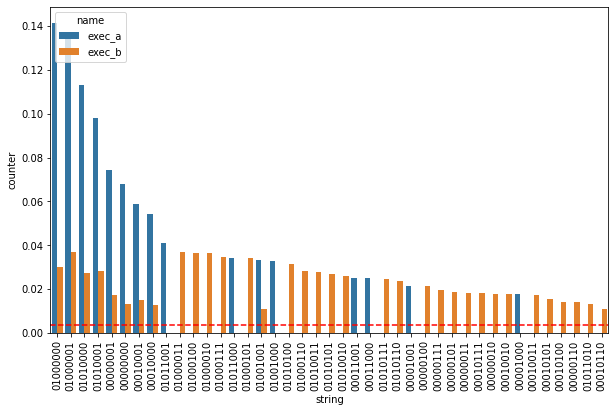

In [141]:
BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID_UNDER_ANALYSIS)
print(f"PROGRAM_ID_UNDER_ANALYSIS: {PROGRAM_ID_UNDER_ANALYSIS}")
RES = execute_programs(
    metadata_source = {"py_file_path": BUG_PATHS["source"]},
    metadata_followup = {"py_file_path": BUG_PATHS["followup"]})
detector = KS_Detector()
_, pval = detector.check(RES["res_A"], RES["res_B"])
print(f"New p-value: {pval}")
OneNightStandInspector(RES["res_A"], RES["res_B"], top_perc=1)